# Processing of a single concrete CT image
## Prolog
**To be written**

## Imports

In [265]:
%load_ext autoreload
%autoreload 2
from functions import CTSlice, QuadraticBackgroundFunction
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit

plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["figure.figsize"] = 12, 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load example slice

In [266]:
image_path = "./dummy_data/1_Probe1_0000,00_0907.png"

ct = CTSlice.import_cv2(image_path, cv2.IMREAD_ANYDEPTH, x_crop=slice(400, 1900), y_crop=slice(300, 1800))
# function to update contour and pore mask based on binary operations
def update_masks(ct):
    ct.calc_contour_mask().dilate_contour_mask(
        iterations=5).erode_contour_mask(
            iterations=5).erode_contour_mask(
                iterations=8).calc_pore_mask(
                    ).dilate_contour_mask(
                    iterations=8)
                    
# function to only update the pore mask
def update_pore_mask(ct):
    ct.dilate_contour_mask(
        iterations=5).erode_contour_mask(
            iterations=5).erode_contour_mask(
                iterations=8).calc_pore_mask(
                    ).dilate_contour_mask(
                    iterations=8)
          
update_masks(ct)
print(ct)

-- CTSlice --
   size            : 1500 x 1500 | uint16
   min intensity   : 0
   max intensity   : 65535
   mean intensity  : 19585.224301777776
   median intensity: 23604.0
source: dummy_data/1_Probe1_0000,00_0907.png


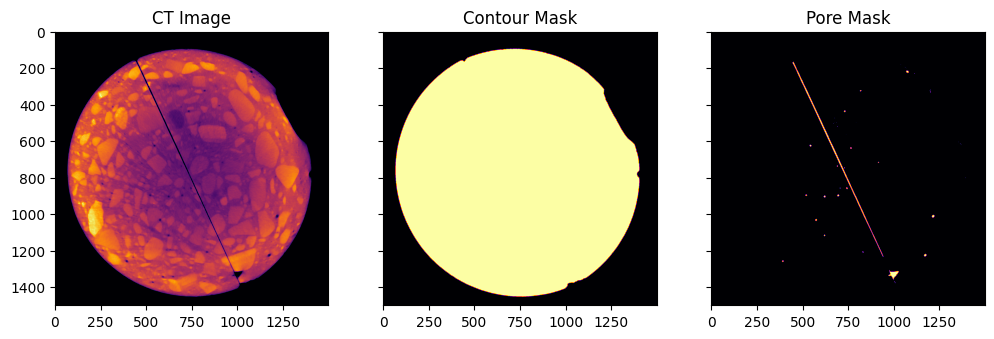

In [267]:
# show masks
fig, ax = plt.subplots(1, 3, sharey=True)

ax[0].set_title("CT Image")
ax[0].imshow(ct.image)
ax[1].set_title("Contour Mask")
ax[1].imshow(ct.contour_mask)
ax[2].set_title("Pore Mask")
ax[2].imshow(ct.pore_mask)

## Centering the slice

In [268]:
method = "hough"
old_center = ct.get_center(method=method)
print(f"Old center: {old_center[0]:.2f}, {old_center[1]:.2f} | deviation from image center: {ct.width/2 - old_center[0]:.2f}, {ct.height/2 - old_center[1]:.2f}")
ct.center_slice(method=method)
update_masks(ct)
new_center = ct.get_center(method=method)
print(f"New center: {new_center[0]:.2f}, {new_center[1]:.2f} | deviation from image center: {ct.width/2 - new_center[0]:.2f}, {ct.height/2 - new_center[1]:.2f}")

Old center: 763.50, 756.50 | deviation from image center: -13.50, -6.50
New center: 750.50, 749.50 | deviation from image center: -0.50, 0.50


-- CTSlice --
   size            : 1500 x 1500 | uint16
   min intensity   : 0
   max intensity   : 65535
   mean intensity  : 19586.396814666667
   median intensity: 23602.0
source: dummy_data/1_Probe1_0000,00_0907.png


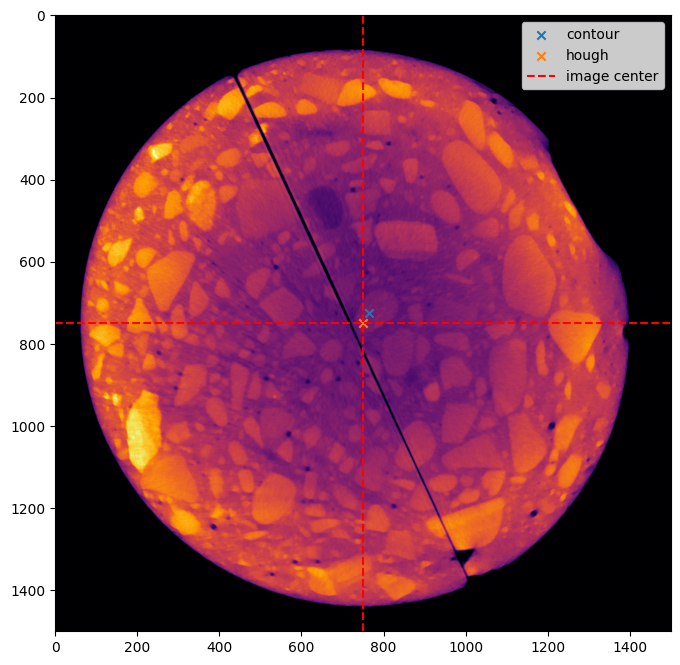

In [269]:
plt.imshow(ct.image)

plt.scatter(*ct.get_center(), marker="x", label="contour")
plt.scatter(*ct.get_center(method="hough"), marker="x", label="hough")
plt.axvline(ct.width/2, c="r", ls="--", label="image center")
plt.axhline(ct.height/2, c="r", ls="--")
plt.legend()
print(ct)

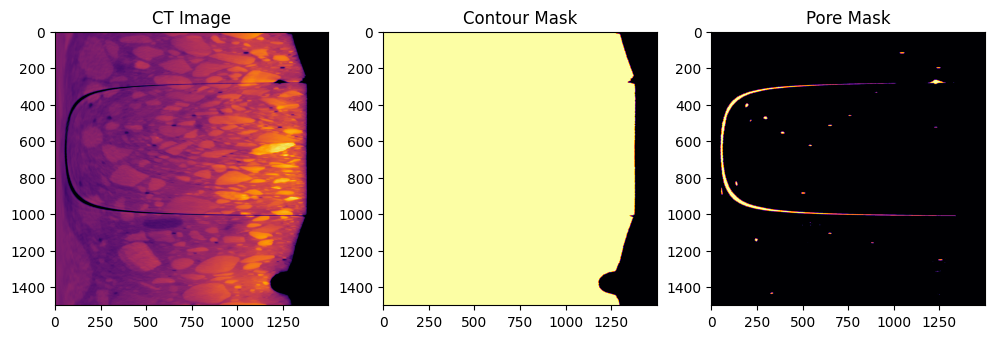

In [270]:
ct.transform(to="polar")

fig, ax = plt.subplots(1, 3)
ax[0].set_title("CT Image")
ax[0].imshow(ct.image)
ax[1].set_title("Contour Mask")
ax[1].imshow(ct.contour_mask)
ax[2].set_title("Pore Mask")
ax[2].imshow(ct.pore_mask)

## Approximating the contour

Since the contour is closed a periodic function is used for the contour approximation. A cropped sine seems to approximate the contour very well.


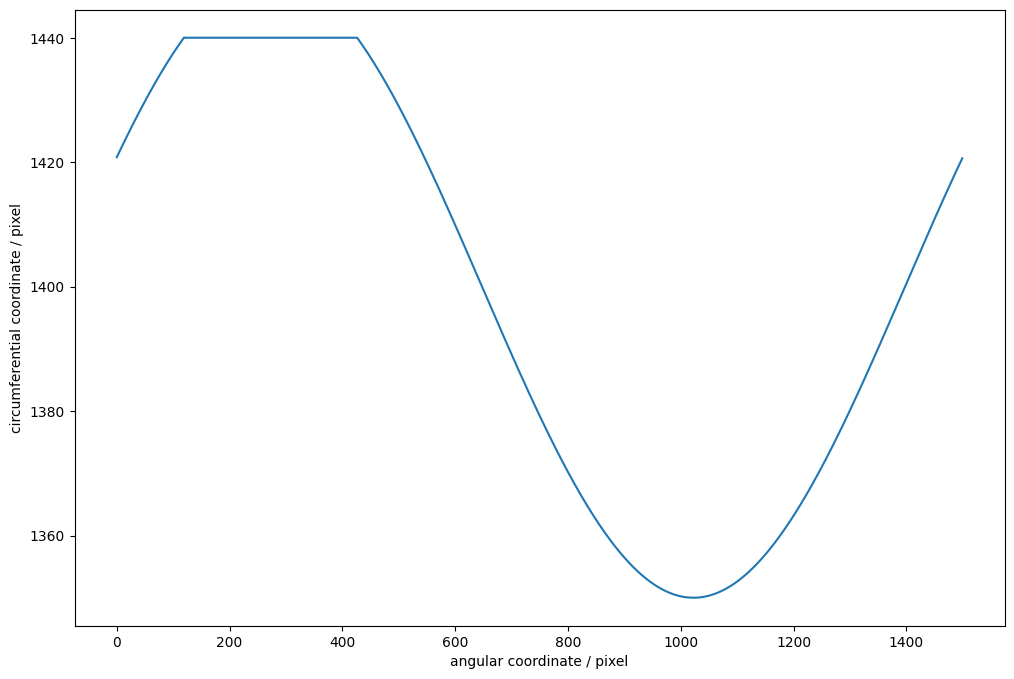

In [271]:
def sine_function(x, y0, ymax, a, b):
    sine = y0 + a * np.sin(1*np.pi*x / ct.width + b)**2
    sine[np.where(sine > ymax)] = ymax
    return sine 

x = np.arange(ct.width)

fig, ax = plt.subplots()
ax.set_xlabel("angular coordinate / pixel")
ax.set_ylabel("circumferential coordinate / pixel")
ax.plot(x, sine_function(x, 0.9 * ct.width, 1440, 100, 1))

A threshold is used to exclude the deep dip from the fit. The threshold is currently defined using `np.percentil`. Maybe this can optimized in future.

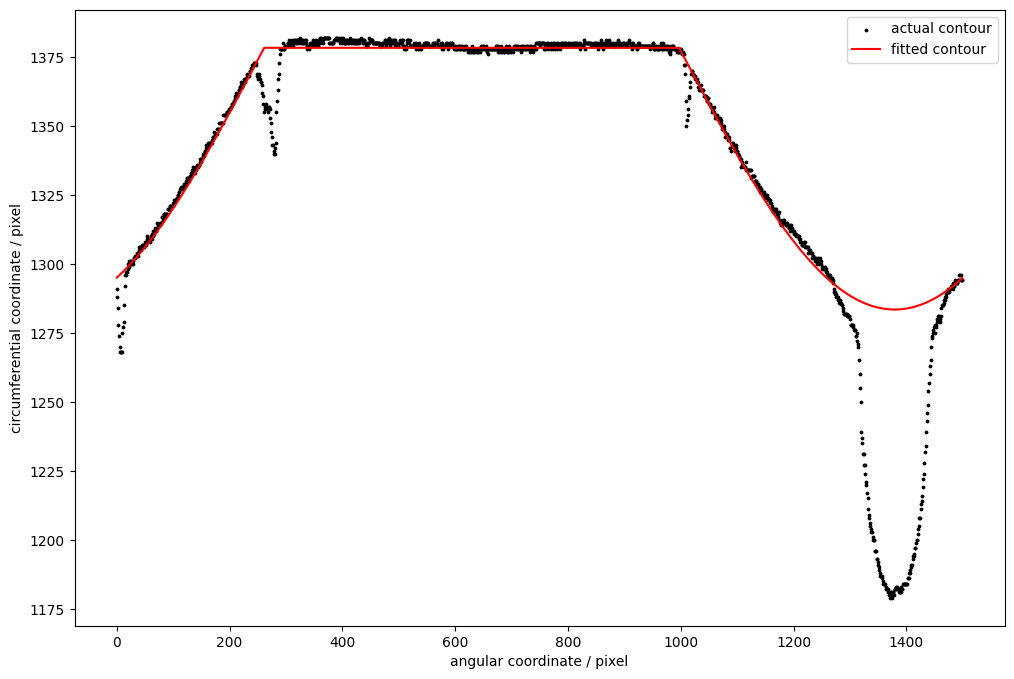

In [272]:
ct.transform(to="polar")
    
contour = np.argmin(ct.contour_mask, axis=1)

fit_thresh = np.percentile(contour, 10)

popt, pcov = curve_fit(
    sine_function, 
    x[np.where(contour > fit_thresh)], 
    contour[np.where(contour > fit_thresh)],
    p0=[1350, 1375, 1, 1]
    )

fig, ax = plt.subplots()
ax.set_xlabel("angular coordinate / pixel")
ax.set_ylabel("circumferential coordinate / pixel")
ax.scatter(x, contour, c="k", s=3, label="actual contour")
ax.plot(x, sine_function(x, *popt), c="r", label="fitted contour")
ax.legend()

## Correct circulartity

Using the approximated contour the image can be manipulated row wise to fit a circle in polar space. Subsequnetly the contour mask is adjusted in polar space because sometimes holes arise after the transformation to linear (cartesian) space.

In [273]:
ct.correct_circularity(np.rint(sine_function(x, *popt)).astype(int))
update_masks(ct)
ct.transform(to="polar")
ct.contour_mask[:, :1000] = 1
update_pore_mask(ct)

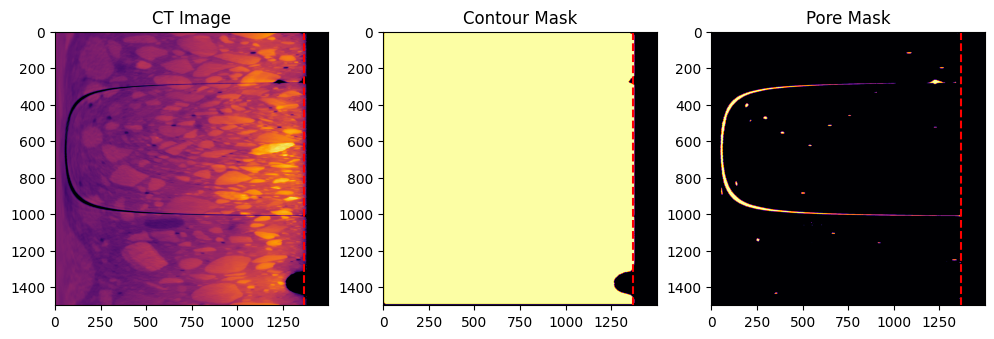

In [274]:
ct.transform(to="polar")

fig, ax = plt.subplots(1, 3)
ax[0].set_title("CT Image")
ax[0].imshow(ct.image)
ax[1].set_title("Contour Mask")
ax[1].imshow(ct.contour_mask)
ax[2].set_title("Pore Mask")
ax[2].imshow(ct.pore_mask)

for axes in ax:
    axes.axvline(np.ceil(np.median(contour)), c="r", ls="--")

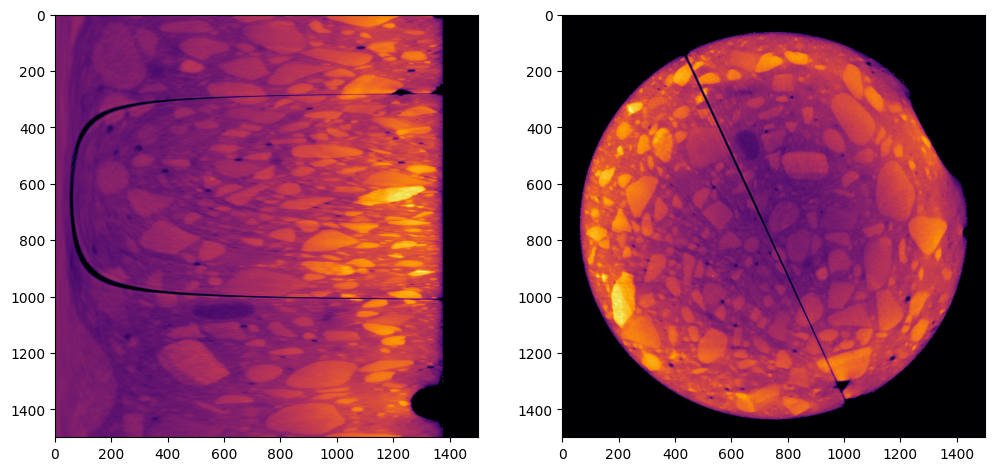

In [275]:
fig, ax = plt.subplots(1, 2)
ct.transform(to="polar")
ax[0].imshow(ct.image)
ct.transform(to="linear")
ax[1].imshow(ct.image)

## Intensity correction

The intensity correction is perfommed by fitting a generic intensity profile to the mean intensity of the image in polar space. Afterwards the circumferential axis is divided by this mean intensity profile which evens out the intensity distribution.

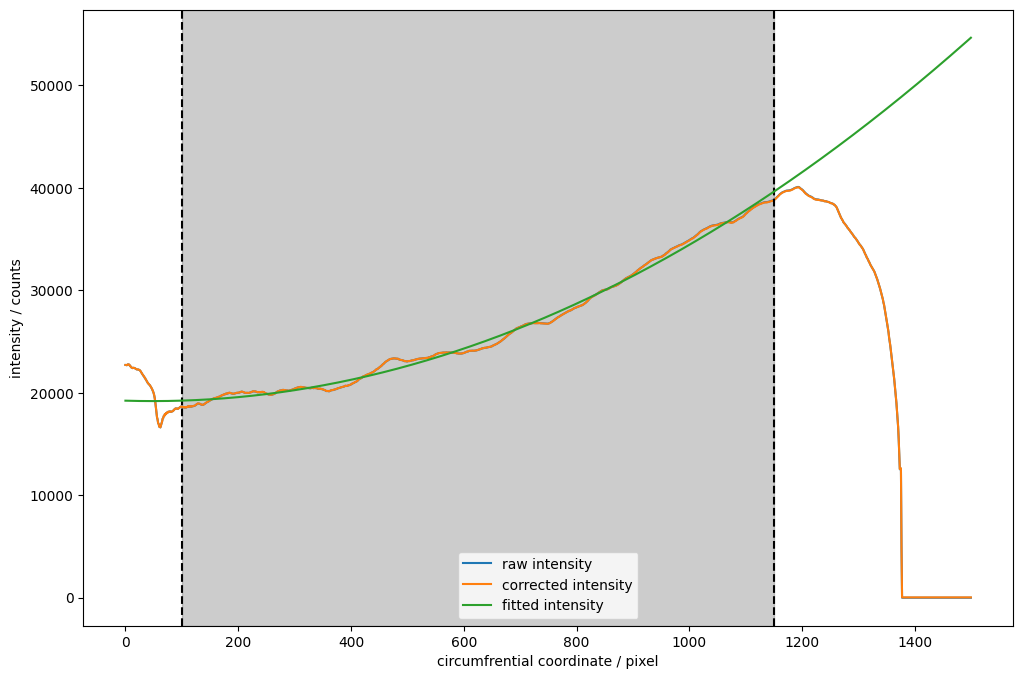

In [276]:
ct.transform(to="polar")
fig, ax = plt.subplots()
ax.set_xlabel("circumfrential coordinate / pixel")
ax.set_ylabel("intensity / counts")

ax.plot(ct.image.mean(axis=0), label="raw intensity")

# create a temporary image where pores are filled with median value
tmp_img = ct.image.copy()
tmp_img[ct.pore_mask] = ct.median
ax.plot(tmp_img.mean(axis=0), label="corrected intensity")

# fit intensity profile
x_min = 100
x_max = 1150
for x in [x_min, x_max]:
    ax.axvline(x, ls="--", c="k")
ax.axvspan(x_min, x_max, color="k", alpha=0.2)

quad = QuadraticBackgroundFunction()
quad.fit(np.arange(x_min, x_max), tmp_img.mean(axis=0)[x_min:x_max])

ax.plot(quad.eval(np.arange(ct.width)), label="fitted intensity")
ax.legend()

In [277]:
# correct image
f = quad.eval(np.arange(ct.width))
image = ct.image.copy() / ((f/f.max()))
image -= image.min()
image /= image.max()
image = image * ct.dtype_max

# over write current ct image
ct.image = image

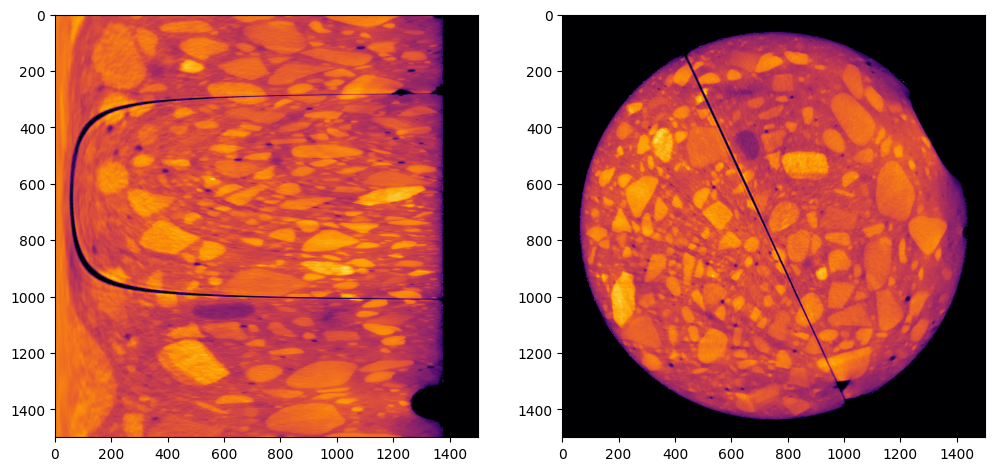

In [278]:
fig, ax = plt.subplots(1, 2)
ct.transform(to="polar")
ax[0].imshow(ct.image)
ct.transform(to="linear")
ax[1].imshow(ct.image)

## Final result

Comparing the raw image to the processed one.

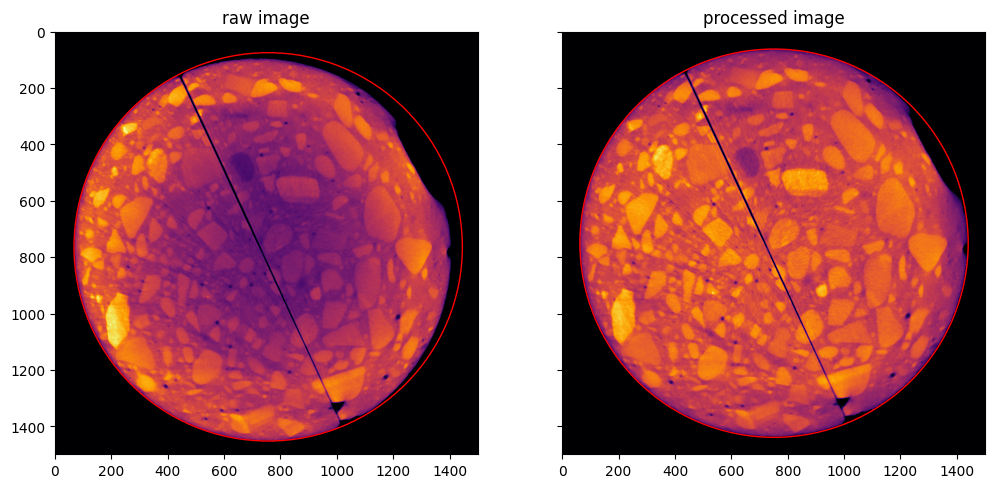

In [280]:
from matplotlib.patches import Circle

ct_raw = CTSlice.import_cv2(image_path, cv2.IMREAD_ANYDEPTH, x_crop=slice(400, 1900), y_crop=slice(300, 1800))
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].set_title("raw image")
ax[0].imshow(_raw_image)
c = Circle(*ct_raw.hough_transform(), fill=False, color="red")
ax[0].add_artist(c)

ax[1].set_title("processed image")
ax[1].imshow(ct.image)
c = Circle(*ct.hough_transform(), fill=False, color="red")
ax[1].add_artist(c)

## Stack Processing

In [ ]:
from pathlib import Path
from functions import QuadraticBackgroundFunction
from skimage.exposure import match_histograms
from skimage.exposure import rescale_intensity

import numpy as np
from copy import deepcopy

def image_to_float(image):
    image = image - image.min()
    image = image / image.max()
    return image


image_paths = Path("/disk7102/home/kluwe/Schreibtisch/concrete_ct/images_obs")
base_dir = image_paths.parents[0]
save_dir = base_dir.joinpath("new_processing")

save_dir.mkdir(exist_ok=True)

reference = None
for image_path in sorted(image_paths.glob("*.png")):
    print(f"processing: {image_path!s}")
    ct = CTSlice.import_cv2(image_path, cv2.IMREAD_ANYDEPTH, x_crop=slice(300, 1800), y_crop=slice(400, 1900))
    def update_masks():
        ct.calc_contour_mask().dilate_contour_mask(
            iterations=10).erode_contour_mask(
                iterations=10).erode_contour_mask(
                    iterations=8).calc_pore_mask(
                        ).dilate_contour_mask(
                        iterations=8)
                    
    update_masks()
    ct.center_slice()
    update_masks()
    # ct_ = deepcopy(ct)
    # ct_.correct_circularity(iterations=15)
    ct.correct_circularity(iterations=15)
    tmp_img = ct.image.copy()
    tmp_img[ct.pore_mask] = ct.median
    # average along angular axis
    f = tmp_img.mean(axis=0)

    # fit intensity profile
    x_min = 200
    x_max = 1100

    quad = QuadraticBackgroundFunction()
    quad.fit(np.arange(x_min, x_max), f[x_min:x_max])

    # correct image
    f = quad.eval(np.arange(0, ct.width))
    ct.transform(to="polar")
    image = ct.image.copy() / ((f/f.max()))

    image -= image.min()
    image /= image.max()
    image *= ct.dtype_max

    ct.image = image.astype(np.uint16)
    ct.transform(to="linear")
    if reference is None:
        reference = ct.image
    matched = match_histograms(ct.image, reference)
    matched = (image_to_float(matched) * ct.dtype_max).astype(np.uint16)
    cv2.imwrite(str(save_dir.joinpath(image_path.name)), matched)
